In [1]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100) 

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

First we define the relevant functions:
The method moving on is rgeatly inspired from problemset 7 and lecture 2

In [5]:
## Defining relevant functions

# a. defining utility of consumption
def utility_of_c(c,rho):
    """
    The function of utility of consumption c
    
    Args:
        c (float): Consumption
        rho (float): Measures the degree of relative risk aversion that is implicit in the utility function
        
    Returns:
           The utility of consumption given the relative risk aversion.
    """
    return c**(1-rho)/(1-rho)

# b. disutility of work
def disutility_of_work(gamma,l):
    """
    The disutility of work
    
    Args:
        gamma (float): coeficient of disutility of work
        l (int,boolean): Register if agents is working l_t = 1 or not l_t = 0
        
    Returns disutility
    """
    return -gamma*l
# c. define function of consumption 
def c(w,h,l,b):
    """
    consumption function
    
    Args:
        w (float): Wage when working
        h (float, list): Level of human capital
        b (float): Benefits of not working
        l (int,boolean): ...
    
    Retruns:
        The consumption function given work or no work
    """
    if l==1:
        c = w*h*l # consumption function if working
    else:
        c = b # consumption function if not working
    return c

In [6]:
# define netutility given human capital and labour
def v2(w,h2,l2,rho,gamma,b):
    """
    Net utility in second period
    
    Args:
        w (float): ...
        h2 (float, list): Human capital second periode
        l2 (int, boolean): dummy for work in second period
        rho (float): ...
        gamma (float): ...
        b(float): ...
    
    Returns: The sum of utility and disutility in the second periode given human capital, h2 and labour, l2
        
    """
    return utility_of_c(c(w,h2,l2,b),rho) + disutility_of_work(gamma,l2)

In [7]:
# Define 
def solve_periode_2(w,h_vec,rho,gamma,b,Delta):
    """
    function for solution in second period: sloves the model in the second periode
    
    Args:
        w (float): ...
        h_vec (list,tuple,ndarray): Vector of the different values of human capital
        rho (float): ...
        gamma (float): ...
        b (float):...
        Delta (float): Is a value to determine high and low accumulation of human capital
    
    Returns:
        l2_vec which is a vector (list) of the optimal labour supply given different values of h.
        v2_vec which is a vecotor (ndarray) of the net-utility given different values of both l and h.
    """
    # a. Grids
    # i. set the number of elements in array
    N = 100
    
    # ii. Create 3 new empty arrays of 100 elemnts without initializing entries
    l2_vec = np.empty(N)
    v2_vec = np.empty(N)
    
    # b. sets l2 = 1 for every h in h_vec that execute a higher utility working than not working.
    # Otherwise let L2 = 0
    for i,h2 in enumerate(h_vec):
        if v2(w,h2,1,rho,gamma,b) >= v2(w,h2,0,rho,gamma,b):
            l2_vec[i] = 1
        else:
            l2_vec[i] = 0
    #c. Generate a vector for net-utility in second period
        v2_vec[i] = v2(w,h2,l2_vec[i],rho,gamma,b)
        
    return v2_vec,l2_vec

# d. call the optimal labour supply, net-utility and consumption
l2_vec, v2_vec = solve_periode_2(w,h_vec,rho,gamma,b,Delta)

# e. construct interpolator (function based on fixed data points)
v2_interp=interpolate.RegularGridInterpolator((h_vec,),v2_vec, bounds_error=False,fill_value=None)

In [8]:
## Making vectors of human capital to display the utility of working and not working
#if consumer choses to work
h2_vec_l = h_vec + 1 + Delta*0.5

#if he chooses not to work
h2_vec_ = h_vec + 0 + Delta*0.5

emptyarray = np.empty(100) # c
nowork_utility = []
for i in emptyarray:
    nowork_utility.append(v2(w,h2_vec_ ,0,rho,gamma,b))

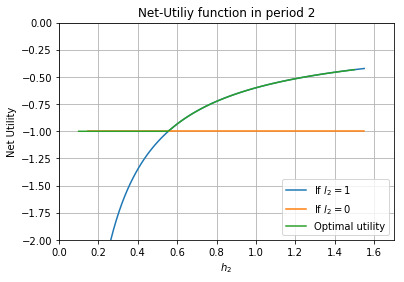

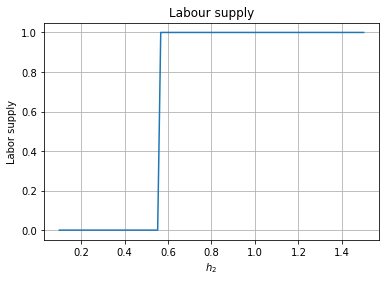

In [9]:
# c. plot
#Sub_fig_1
fig1_1 = plt.figure()
ax1 = fig1_1.add_subplot(1,1,1)
ax1.plot(h2_vec_, v2(w,h2_vec_,1,rho,gamma,b), label = 'If $l_2=1$')
plt.plot(h2_vec_, nowork_utility         , label = 'If $l_2=0$')
ax1.plot(h_vec, l2_vec, label = 'Optimal utility')
ax1.legend(loc='lower right')

ax1.grid()
ax1.set_xlabel('$h_2$')
ax1.set_ylabel('Net Utility')
ax1.set_title('Net-Utiliy function in period 2')
ax1.set_xlim([0,1.7])
ax1.set_ylim([-2,0]);

#sub_fig_2
fig1_2 = plt.figure()
ax2 = fig1_2.add_subplot(1,1,1)
ax2.plot(h_vec, v2_vec, label = 'Labour supply')
ax2.grid()
ax2.set_xlabel('$h_2$')
ax2.set_ylabel('Labor supply')
ax2.set_title('Labour supply')
ax1.legend(loc='lower right')


The green line in the first figure display the optimal utility when only choosing to work after the threshold. As a consequense the second figure display the jump in labour supply from 0 to 1 the moment it gets advantageous to work which is approximately h_2 = 0.56.

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

In [10]:
def v1(w,l1,h1,rho,beta,gamma,Delta,b,v2_interp):
    '''
    function for the net utility of the first period given the expected net utility in second period
    
    Args:
        w (float): ...
        l1 (int, boolean): Dummy for working in period 1
        h1 (float, list): human capital accumulated in periode 1
        rho (float): ...
        beta (float): ...
        gamma (float): ...
        Delta (float): ...
        b (float): ...
        v2_interp (ndarray): is the net utility of periode 2 
    
    Return: The net utility of periode 1.
    '''
    
    # a. v2 value, if working but low human capital
    h2_low = h1 + l1 + 0
    v2_low = v2_interp([h2_low])[0]
   
    # b. v2 value, if working and having high human capital
    h2_high = h1 + l1 + Delta
    v2_high = v2_interp([h2_high])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. net utility
    return utility_of_c(c(w,h1,l1,b),rho) + disutility_of_work(gamma,l1) + beta*v2-1

In [11]:
# periode 1

def solve_periode_1(w,h_vec,rho,beta,gamma,Delta,b,v2_interp):
    """
    function for solution in second period: sloves the model in the second periode
    
    Returns:
        l1_vec which is a vector (list) of the optimal labour supply given different values of h.
        v1_vec which is a vecotor (ndarray) of the net-utility given different values of both l and h.
    """
    # a. Grids
    # i. set the number of elements in array
    N=100
    
    # ii. Create 3 new empty arrays of 100 elemnts without initializing entries
    l1_vec = np.empty(N)
    v1_vec = np.empty(N)
    no_work = np.empty(N)
    
    # b. sets l1 = 1 for every h in h_vec that execute a higher utility working than not working.
    # Otherwise let L1 = 0
    for i, h1 in enumerate(h_vec):
        if v1(w,1,h1,rho,beta,gamma,Delta,b,v2_interp) >= v1(w,0,h1,rho,beta,gamma,Delta,b,v2_interp):
            l1_vec[i] = 1
        else:
            l1_vec[i] = 0
    #c. Generate a vector for net-utility in first period   
        v1_vec[i] = v1(w,l1_vec[i],h1,rho,beta,gamma,Delta,b,v2_interp)
        
    return v1_vec,l1_vec
# d. call the optimal labour supply, net-utility and consumption
v1_vec, l1_vec = solve_periode_1(w,h_vec,rho,beta,gamma,Delta,b,v2_interp)

Text(0.5, 1.0, 'Labour supply')

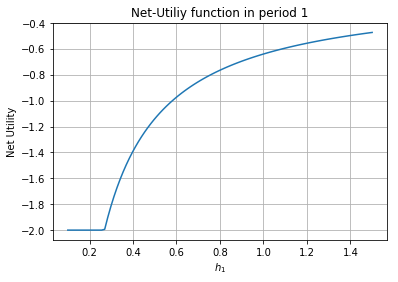

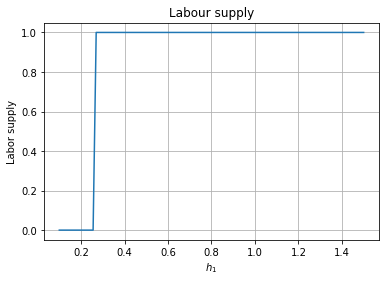

In [12]:
# plot
#Sub_fig_1
fig2_1 = plt.figure()
ax1 = fig2_1.add_subplot(1,1,1)
ax1.plot(h_vec, v1_vec, label = 'Optimal utility')

ax1.grid()
ax1.set_xlabel('$h_1$')
ax1.set_ylabel('Net Utility')
ax1.set_title('Net-Utiliy function in period 1')

#sub_fig_2
fig2_2 = plt.figure()
ax2 = fig2_2.add_subplot(1,1,1)
ax2.plot(h_vec, l1_vec, label = 'Labour supply')

ax2.grid()
ax2.set_xlabel('$h_1$')
ax2.set_ylabel('Labor supply')
ax2.set_title('Labour supply')

It is the same result as in periode 2, that for low enough human capital you wont work.

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

By using the plots already shown we can state that with benefits higher than wages the agent will still choose to work given high enough human capital.

In [13]:
def interactive_figure(w,beta,b,):
    
    l2_vec, v2_vec = solve_periode_2(w,h_vec,rho,gamma,b,Delta)
    l1_vec, v1_vec = solve_periode_1(w,h_vec,rho,beta,gamma,Delta,b,v2_interp)
    
   
   
    # b. figure
    fig1_1 = plt.figure()
    ax1 = fig1_1.add_subplot(1,1,1)
    ax1.plot(h2_vec_, v2(w,h2_vec_,1,rho,gamma,b), label = 'If $l_2=1$')
    plt.plot(h2_vec_, nowork_utility         , label = 'If $l_2=0$')
    ax1.plot(h_vec, l2_vec, label = 'Optimal utility')
    ax1.legend(loc='lower right')

    ax1.grid()
    ax1.set_xlabel('$h_2$')
    ax1.set_ylabel('Net Utility')
    ax1.set_title('Net-Utiliy function in period 2')
    ax1.set_xlim([0,1.7])
    ax1.set_ylim([-2,0])
    
    fig2_1 = plt.figure()
    ax2 = fig2_1.add_subplot(1,1,1)
    ax2.plot(h_vec, l1_vec, label = 'Optimal utility')

    ax2.grid()
    ax2.set_xlabel('$h_1$')
    ax2.set_ylabel('Net Utility')
    ax2.set_title('Net-Utiliy function in period 1');


widgets.interact(interactive_figure,
    w=widgets.FloatSlider(description="wage", min=0, max=3, step=0.1, value=2),
    b=widgets.FloatSlider(description="benefits", min=0, max=3, step=0.1, value=1),
    beta=widgets.FloatSlider(description="$beta$", min=0, max=3, step=0.1, value=0.96),
);

interactive(children=(FloatSlider(value=2.0, description='wage', max=3.0), FloatSlider(value=0.96, description…

It is a little difficult to see it in periode 1 because we were unable to figure out how to show work and non work in that periode, however it is still possible to see the last kink in the curve where i gets rounded. That is where the agent starts working. So given high enough human capital.

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [4]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [5]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [6]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [2]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
    #draw alphas
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))

#draw betas
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

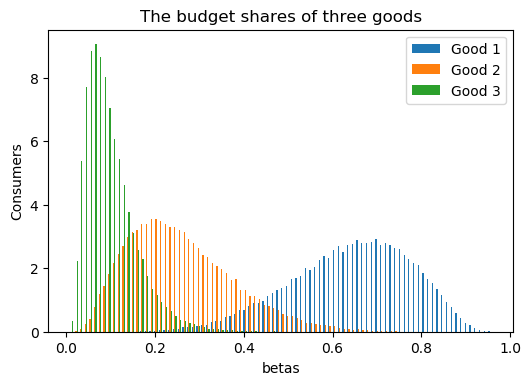

In [3]:
## plot histogram of budgetshares of the three goods
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.hist(betas,bins=90,density=True,label=['Good 1', 'Good 2', 'Good 3'])
ax.set_title('The budget shares of three goods')
ax.set_xlabel('betas')
ax.set_ylabel('Consumers')
ax.legend(loc='upper right');

The budget shares are given by the fraction of demand of each good:

$$
\begin{eqnarray*}
\frac{x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})}{I}&=& \frac{\beta^{j}_i\frac{I^j}{p_{i}}}{I} &=& \frac{\beta^{j}_i}{p_{i}}  \\
\end{eqnarray*}
$$

The y-axis indicate consumers pr thousands, and the beta tells us the share of their budget they use on each good. As can be seen from the histogram consumers use the moste of their budget on good 1. Then good 2 and lastly good 3.

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

In [4]:
## Slicing the arrays 
print(betas)

[[0.53104511 0.30693723 0.16201766]
 [0.50866997 0.4162364  0.07509363]
 [0.83317207 0.07722226 0.08960567]
 ...
 [0.63725404 0.22027742 0.14246854]
 [0.78205036 0.11988119 0.09806844]
 [0.65552751 0.24728801 0.09718448]]


In [5]:
## We want to slice the arrays so we can define the demand of each good
## taking all rows (:) but keeping the first column (1) and so on

beta_g1 = betas[:,0]
beta_g1

array([0.53104511, 0.50866997, 0.83317207, ..., 0.63725404, 0.78205036,
       0.65552751])

In [6]:
beta_g3 = betas[:,2]
beta_g3

array([0.16201766, 0.07509363, 0.08960567, ..., 0.14246854, 0.09806844,
       0.09718448])

In [7]:
## The method used is greatly inspired from problemset 2 and 7 and lecture 3 and 4

# a. Define demandfunctions

def demand_g1(betas,e1,e2,e3,p1,p2):
    '''
    calculates the demand of good 1
    
    Args:
        p1 (float): Price for good 1
        p2 (float): Price for good 2
        e1 (numpy array): Endowments of good 1
        e2 (numpy array): Endowments of good 2
        e3 (numpy array): Endowments of good 3
        betas (type: numpy ndarray): Preferences for goods
        
    Return: Demand of good 1. (It is the same arguments for all goods)
    '''
    I = p1*e1+p2*e2+e3
    return betas[:,0]*I/p1

def demand_g2(betas,e1,e2,e3,p1,p2):
    I = p1*e1+p2*e2+e3
    return betas[:,1]*I/p2

# As p3 = 1 we do not need to specify the demand of good 3

In [8]:
# b. Calculate excess demand
# excess demand good 1
def excess_demand_g1(betas, p1, p2, e1, e2, e3):
    """
    Calculating excess demand of good 1
    
    Returns:
        excess (float): Excess demand of good 1
    """
    # i. sum array of demand
    demand = np.sum(demand_g1(betas,e1,e2,e3,p1,p2))
    
    # ii. sum array of supply
    supply = np.sum(e1)
    
    # iii. Calculate excess demand
    excess_demand = demand - supply
    
    return excess_demand

# excess demand good 2
def excess_demand_g2(betas, p1, p2, e1, e2, e3):
    
    # i. sum array of demand
    demand = np.sum(demand_g2(betas,e1,e2,e3,p1,p2))
    
    # ii. sum array of supply
    supply = np.sum(e2)
    
     # iii. Calculate excess demand
    excess_demand = demand - supply
    
    return excess_demand

In [9]:
# to illustrate the excess demand function we need to specify pricevectors of p1
# and p2. We can then fill the numpy arrays (grids) of the excess demand functions.

# a. choosing number of values and maximum price
p_max = 10
seize = 100
shape_tuple = (seize,seize)

# b. Generating arrays of prices
p1_vec = np.linspace(0.1,p_max,seize)
p2_vec = np.linspace(0.1,p_max,seize)

# c. allocate numpy arrays
excess1_grid = np.empty(shape_tuple)
excess2_grid = np.empty(shape_tuple)

# d. Transforming price-vectors to grids
p1_grid,p2_grid = np.meshgrid(p1_vec,p2_vec,indexing='ij')

for i,p1 in enumerate(p1_vec):
    for j,p2 in enumerate(p2_vec):
        excess1_grid[i,j] = excess_demand_g1(betas, p1, p2, e1, e2, e3)
        excess2_grid[i,j] = excess_demand_g2(betas, p1, p2, e1, e2, e3)

''

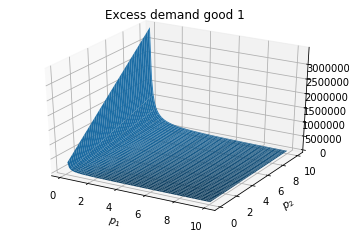

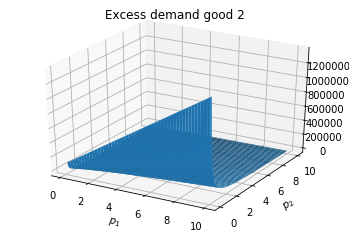

In [10]:
fig = plt.figure() # create the figure
ax = fig.add_subplot(1,1,1,projection='3d') # create a 3d axis in the figure 
ax.plot_surface(p1_grid,p2_grid,excess1_grid)
ax.set_title('Excess demand good 1')
ax.set_xlabel('$p_1$')
ax.set_ylabel('$p_2$')



fig = plt.figure() # create the figure
ax1 = fig.add_subplot(1,1,1,projection='3d') # create a 3d axis in the figure 
ax1.plot_surface(p1_grid,p2_grid,excess2_grid)
ax1.set_title('Excess demand good 2')
ax1.set_xlabel('$p_1$')
ax1.set_ylabel('$p_2$')

;

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

In [11]:

# equilibrium function
def find_equilibrium(betas,p1,p2,p3,e1,e2,e3,kappa=0.5,eps=1e-8,maxiter=50000):
    
    t = 1
    while True:
        
        # a. step 1: excess demand
        Z1 = excess_demand_g1(betas, p1, p2, e1, e2, e3)
        Z2 = excess_demand_g2(betas, p1, p2, e1, e2, e3)
        
        # b. step 2: stop?
        if (np.abs(Z1) < eps or np.abs(Z2) < eps) or t >= maxiter:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
            print(f'{t:3d}: p2 = {p2:12.8f} -> excess demand -> {Z2:14.8f}')
            break
        
        # c. step 3: update p1 and p2
        p1 = p1 + kappa*Z1/N
        p2 = p2 + kappa*Z2/N
        
        # d. step 4: return
        if t < 5 or t%2500 == 0:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
            print(f'{t:3d}: p2 = {p2:12.8f} -> excess demand -> {Z2:14.8f}')
        elif t == 5:
            print ('    ...')
            
         
        t += 1 # Updating iteration counter
    
    return p1, p2

In [12]:
# find equilibrium function
p1 = 5
p2 = 2
p3 = 1
kappa = 0.1
eps = 1e-8
p1,p2 = find_equilibrium(betas,p1,p2,p3,e1,e2,e3,kappa=kappa,eps=eps)

  1: p1 =   5.00275451 -> excess demand ->  1377.25348781
  1: p2 =   2.00357081 -> excess demand ->  1785.40484742
  2: p1 =   5.00553344 -> excess demand ->  1389.46580224
  2: p2 =   2.00703918 -> excess demand ->  1734.18452208
  3: p1 =   5.00833527 -> excess demand ->  1400.91730723
  3: p2 =   2.01040972 -> excess demand ->  1685.27131126
  4: p1 =   5.01115856 -> excess demand ->  1411.64436855
  4: p2 =   2.01368682 -> excess demand ->  1638.54765189
    ...
2500: p1 =   6.47759971 -> excess demand ->    11.41316878
2500: p2 =   2.61204736 -> excess demand ->     4.25784940
5000: p1 =   6.48992621 -> excess demand ->     0.11792691
5000: p2 =   2.61664590 -> excess demand ->     0.04399355
7500: p1 =   6.49005381 -> excess demand ->     0.00122304
7500: p2 =   2.61669350 -> excess demand ->     0.00045627
10000: p1 =   6.49005513 -> excess demand ->     0.00001268
10000: p2 =   2.61669400 -> excess demand ->     0.00000473
12500: p1 =   6.49005515 -> excess demand ->     0.000

We thus get that the Walras-equilibrium price for good 1 is 6.49 and good 2 is 2.61

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

To do that we will first define the utility function. Then we can calculate the utility for all consumers, goods and with newly found prices. We can then plot the distribution of the utility.

In [29]:
#Deine utility function
def utility(betas, p1, p2, e1, e2, e3,gamma):    
    I = p1*e1+p2*e2+e3
    x1 = betas[:,0]*(I/p1)
    x2 = betas[:,1]*(I/p2)
    x3 = betas[:,2]*I
    
    return (x1**betas[:,0]*x2**betas[:,1]*x3**betas[:,2])**gamma

Text(0.5, 1.0, 'Utilities Distribution')

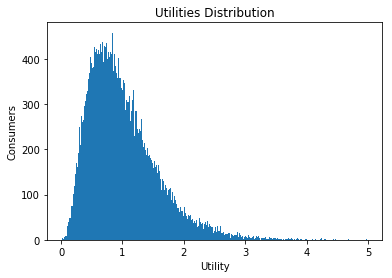

In [34]:
u_vec = utility(betas,p1, p2, e1, e2, e3, gamma)

plt.hist(u_vec,bins =500) #every bin represents 1000 consumers

plt.xlabel('Utility')
plt.ylabel('Consumers')
plt.title('Utilities Distribution')

In [35]:
## We can now caluculate the mean and variance.
mean = np.mean(u_vec)
variance = np.var(u_vec)

mean,variance

(1.0101644598643857, 0.31734020500163673)

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

In [32]:
#The approch is the same, but with a new e. 
e = e1

In [33]:
## The method used is greatly inspired from problemset 2 and 7 and lecture 3 and 4

# a. Define demandfunctions

def demand_g1_new(betas,e,p1_new,p2_new):

    I = p1_new*e+p2_new*e+e
    return betas[:,0]*I/p1_new

def demand_g2_new(betas,e,p1_new,p2_new):
    
    I = p1_new*e+p2_new*e+e
    return betas[:,1]*I/p2_new

# As p3 = 1 we do not need to specify the demand of good 3

In [34]:
# b. Calculate excess demand
# excess demand good 1
def excess_demand_g1_new(betas,e,p1_new,p2_new):
    """
    Calculating excess demand of good 1
    
    Returns:
        excess (float): Excess demand of good 1
    """
    # i. sum array of demand
    demand = np.sum(demand_g1_new(betas,e,p1_new,p2_new))
    
    # ii. sum array of supply
    supply = np.sum(e)
    
    # iii. Calculate excess demand
    excess_demand = demand - supply
    
    return excess_demand

# excess demand good 2
def excess_demand_g2_new(betas,e,p1_new,p2_new):
    
    # i. sum array of demand
    demand = np.sum(demand_g2_new(betas,e,p1_new,p2_new))
    
    # ii. sum array of supply
    supply = np.sum(e)
    
     # iii. Calculate excess demand
    excess_demand = demand - supply
    
    return excess_demand

In [37]:

# equilibrium function
def find_equilibrium_new(betas,p1_new,p2_new,p3_new,e,kappa=0.5,eps=1e-8,maxiter=50000):
    
    t = 0
    while True:
        
        # a. step 1: excess demand
        Z1 = excess_demand_g1_new(betas,e,p1_new,p2_new)
        Z2 = excess_demand_g2_new(betas,e,p1_new,p2_new)
        
        # b. step 2: stop?
        if (np.abs(Z1) < eps or np.abs(Z2) < eps) or t >= maxiter:
            print(f'{t:3d}: p1_new = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
            print(f'{t:3d}: p2_new = {p2:12.8f} -> excess demand -> {Z2:14.8f}')
            break
        
        # c. step 3: update p1 and p2
        p1_new = p1_new + kappa*Z1/N
        p2_new = p2_new + kappa*Z2/N
        
        # d. step 4: return
        if t < 5 or t%2500 == 0:
            print(f'{t:3d}: p1_new = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
            print(f'{t:3d}: p2_new = {p2:12.8f} -> excess demand -> {Z2:14.8f}')
        elif t == 5:
            print ('    ...')
            
         
        t += 1 # Updating iteration counter
    
    return p1_new, p2_new

In [38]:
# find equilibrium function
p1_new = 5
p2_new = 2
p3_new = 1
kappa = 0.5
eps = 1e-8
p1_new,p2_new = find_equilibrium_new(betas,p1_new,p2_new,p3_new,e,kappa=0.5,eps=1e-8,maxiter=50000)

  0: p1_new =   6.49000000 -> excess demand -> 98641966.82162084
  0: p2_new =   2.61700000 -> excess demand -> 75732668.40843812
  1: p1_new =   6.49000000 -> excess demand -> 101167836.37735206
  1: p2_new =   2.61700000 -> excess demand -> 53035817.46182784
  2: p1_new =   6.49000000 -> excess demand -> 94134619.03151079
  2: p2_new =   2.61700000 -> excess demand -> 58723633.64492429
  3: p1_new =   6.49000000 -> excess demand -> 93753517.80718455
  3: p2_new =   2.61700000 -> excess demand -> 59081961.66602881
  4: p1_new =   6.49000000 -> excess demand -> 93645553.44944049
  4: p2_new =   2.61700000 -> excess demand -> 59181379.87152798
    ...
2500: p1_new =   6.49000000 -> excess demand -> 93519675.86399658
2500: p2_new =   2.61700000 -> excess demand -> 59282896.44600989
5000: p1_new =   6.49000000 -> excess demand -> 93519663.44944806
5000: p2_new =   2.61700000 -> excess demand -> 59282888.86201406
7500: p1_new =   6.49000000 -> excess demand -> 93519659.33700047
7500: p2_ne

So we think that we have the right approach by defining a e that such all have the same endowment, but somthing is going wrong and  we can not find the error.